## Аналитика в Яндекс.Афише

Имеются данные сервиса Яндекс.Афиша. Необходимо определить
- как люди пользуются продуктом
- когда они начинают покупать,
- сколько денег приносит каждый клиент
- когда клиент окупается.

Описание данных\
**Таблица visits (лог сервера с информацией о посещениях сайта):**\
Uid — уникальный идентификатор пользователя\
Device — категория устройства пользователя\
Start Ts — дата и время начала сессии\
End Ts — дата и время окончания сессии\
Source Id — идентификатор рекламного источника, из которого пришел пользователь\
**Таблица orders (информация о заказах):**\
Uid — уникальный id пользователя, который сделал заказ\
Buy Ts — дата и время заказа\
Revenue — выручка Яндекс.Афиши с этого заказа\
**Таблица costs (информация о затратах на маркетинг):**\
source_id — идентификатор рекламного источника\
dt — дата\
costs — затраты на этот рекламный источник в этот день\

### Шаг 1. Загрузка данных и подготовка их к анализу.

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np

In [69]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

In [70]:
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [71]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [72]:
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [73]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [74]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [75]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [76]:
visits.columns = visits.columns.str.lower()
visits = visits.rename(columns={'start ts':'start_ts', 'end ts':'end_ts', 'source id':'source_id'})
visits['end_ts'] = pd.to_datetime(visits['end_ts'], format='%Y-%m-%d %H:%M:%S')
visits['start_ts'] = pd.to_datetime(visits['start_ts'], format='%Y-%m-%d %H:%M:%S')
costs['dt'] = pd.to_datetime(costs['dt'], format='%Y-%m-%d')
visits

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485


In [77]:
orders.columns = orders.columns.str.lower()
orders = orders.rename(columns={'buy ts':'buy_ts'})
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'], format='%Y-%m-%d')
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null datetime64[ns]
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [78]:
costs['dt'] = pd.to_datetime(costs['dt'], format='%Y-%m-%d')
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


### Вывод.

На данном этапе названия колонок в таблицах были приведены к нижнему регистру, а также для удобства добавлены символы нижнего подчеркивания между словами, где это было необходимо. Столбцы с датой переведены в соотвутствующий формат.

## Шаг 2. Постройте отчёты и посчитайте метрики.

In [79]:
visits[['end_ts','start_ts']].describe()

,end_ts,start_ts
count,359400,359400
unique,224760,224303
top,2017-11-24 16:51:00,2017-11-24 16:06:00
freq,23,19
first,2017-06-01 00:02:00,2017-06-01 00:01:00
last,2018-06-01 01:26:00,2018-05-31 23:59:00


Видим, что в июне 2018 года статистика собиралась только лишь полтора часа! Естественно, посещений и покупок будет несравненно мало. Чтобы эти записи не исказили результаты, не будем учитывать это в дальнейших расчетах, т.е. будем считать, что данные собирались с 1 июня 2017 по 31 мая 2018.

In [80]:
orders['buy_ts'].describe()

count                   50415
unique                  45991
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-06-01 00:02:00
Name: buy_ts, dtype: object

Аналогичным образом стоит поступить и с данными по продажам, т.к. в июне 2018 года есть данные только за 2 минуты. Удалим эти строки.

In [81]:
orders = orders[orders['buy_ts'] != orders['buy_ts'].max()]

In [82]:
# добавляем дату, неделю, месяц и год начала сессии в отдельные колонки
visits['session_date'] = visits['start_ts'].dt.date
visits['session_week'] = visits['start_ts'].dt.week
visits['session_month'] = visits['start_ts'].dt.month
visits['session_year'] = visits['start_ts'].dt.year
visits['session_date'] = pd.to_datetime(visits['session_date'])
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 9 columns):
device           359400 non-null object
end_ts           359400 non-null datetime64[ns]
source_id        359400 non-null int64
start_ts         359400 non-null datetime64[ns]
uid              359400 non-null uint64
session_date     359400 non-null datetime64[ns]
session_week     359400 non-null int64
session_month    359400 non-null int64
session_year     359400 non-null int64
dtypes: datetime64[ns](3), int64(4), object(1), uint64(1)
memory usage: 24.7+ MB


In [83]:
# удаляем строки с данными за 1 июня 2018
visits = visits[(visits['session_date'] != '2018-06-01') & (visits['end_ts'] < '2018-06-01')]
# пользовательская активность по датам: число уникальных пользователей в определенный день
daus=visits.groupby('session_date').agg({'uid':'nunique'})
visits.groupby('session_date').agg({'uid':'nunique'}).describe()

,uid
count,364.000000
mean,907.967033
std,370.441259
min,1.000000
25%,594.000000
50%,921.000000
75%,1173.000000
max,3319.000000


In [84]:
daus[daus['uid']==1]

,uid
session_date,
2018-03-31,1


Интересно, что случилось 31 марта 2018. Может, такое мизерное число посетителей связано с тем, что сайт упал?\
Посчитаем метрики DAU, WAU, MAU:

In [85]:
dau = int(daus.mean()[0])
print('daily active users - ', dau)

daily active users -  907


In [86]:
wau = int(visits.groupby(['session_year', 'session_week']).agg({'uid':'nunique'}).mean())
print('weekly active users - ', wau)

weekly active users -  5716


In [87]:
mau = int(visits.groupby(['session_year', 'session_month']).agg({'uid':'nunique'}).mean())
print('monthly active users - ', mau)

monthly active users -  23227


Среднее число сессий в день:

In [88]:
session_per_day = visits.groupby('session_date')['uid'].count().mean()
int(session_per_day)

987

Средняя длительность сессии:

In [89]:
visits['session_duration'] = (visits['end_ts'] - visits['start_ts']).dt.seconds # длительность сессии в секундах
asl = visits['session_duration'].mean()
asl

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


643.4657028058812

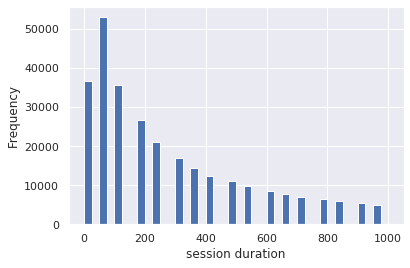

In [90]:
# построим распределение числа сессий по длительности
sb.set()
visits['session_duration'].plot(kind='hist', bins=40, range=(0,1000))
plt.xlabel('session duration')
plt.show()

Больше всего сессий продолжительности 2-3 минуты.

Как часто люди возвращаются? Чтобы ответить на этот вопрос проведем когортный анализ, где посчитаем retention. Когортой будем считать группу пользователей, которые впервые пришли на сайт в определенном месяце.

In [91]:
visits['month_visit'] = visits['session_date'].astype('datetime64[M]') # выделяем месяц
# выделяем месяц первого визита на сайт для каждого юзера
first_visits = (visits
                        .groupby('uid')
                        .agg({'session_date':'min'})
                        .rename(columns={'session_date':'first_visit'})
                        .reset_index()
               )
visits = visits.merge(first_visits, on='uid') # соединяем с исходной таблицей

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [92]:
visits['first_month_visit'] = visits['first_visit'].astype('datetime64[M]')
# добавим лайфтайм когорт
visits['cohort_lifetime'] = (((visits['month_visit'] - visits['first_month_visit']) / np.timedelta64(1,'M')).round()).astype('int')

In [93]:
visits

,device,end_ts,source_id,start_ts,uid,session_date,session_week,session_month,session_year,session_duration,month_visit,first_visit,first_month_visit,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,51,12,2017,1080,2017-12-01,2017-12-20,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,8,2,2018,1680,2018-02-01,2018-02-19,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,26,7,2017,0,2017-07-01,2017-07-01,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,20,5,2018,1440,2018-05-01,2018-03-09,2018-03-01,2
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-09,10,3,2018,1680,2018-03-01,2018-03-09,2018-03-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359383,desktop,2017-11-08 13:39:00,4,2017-11-08 13:39:00,6761309174945977743,2017-11-08,45,11,2017,0,2017-11-01,2017-11-08,2017-11-01,0
359384,desktop,2017-07-31 12:31:00,3,2017-07-31 12:13:00,11102751930812818282,2017-07-31,31,7,2017,1080,2017-07-01,2017-07-31,2017-07-01,0
359385,desktop,2018-03-20 15:25:00,4,2018-03-20 15:11:00,272012551460639309,2018-03-20,12,3,2018,840,2018-03-01,2018-03-20,2018-03-01,0
359386,touch,2018-04-03 11:23:00,5,2018-04-03 11:19:00,3266363999948772866,2018-04-03,14,4,2018,240,2018-04-01,2018-04-03,2018-04-01,0


In [95]:
def cohorts_one_source(df):
    
    # драфт таблицы с число уникальных пользователей в каждой когорте в зависимости от возраста когорты
    cohorts = (df
                .groupby(['first_month_visit', 'cohort_lifetime'])
                .agg({'uid':'nunique'})
                .reset_index()
                .rename(columns={'uid':'n_users'})
              )
    # сделаем отдельную таюлицу, где будут лежать размеры когорт (число посетителей на начальный период каждой когорты)
    cohort_sizes = (df[df['cohort_lifetime'] == 0]
                        .groupby('first_month_visit')
                        .agg({'uid':'nunique'})
                        .reset_index()
                        .rename(columns={'uid':'cohort_size'})
                   )
    # добавим это в общую таблицу с когортами
    cohorts_final = cohorts.merge(cohort_sizes, on='first_month_visit')
    # считаем retention
    cohorts_final['retention'] = cohorts_final.n_users / cohorts_final.cohort_size
    return cohorts_final

def retention_one_source(df):
    source = df['source_id'].unique()[0]
    retention = cohorts_one_source(df).groupby('cohort_lifetime')['retention'].mean().reset_index()
    retention.columns = ['cohort_lifetime',"retention_{}_source".format(source)]
    return retention

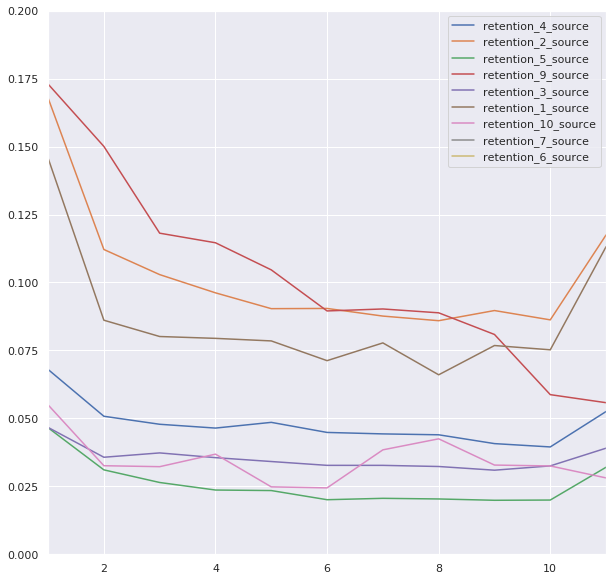

In [96]:
sources = visits['source_id'].unique()
#retention_one_source(visits[visits['source_id'] == 1])

retention_all_sources = retention_one_source(visits[visits['source_id'] == sources[0]])
for item in sources[1::]:
    retention_all_sources = retention_all_sources.merge(retention_one_source(visits[visits['source_id'] == item]), on='cohort_lifetime', how='left')
retention_all_sources.drop('cohort_lifetime', axis=1).plot(figsize=(10,10))
plt.xlim(1,11)
plt.ylim(0,0.2)
plt.show()

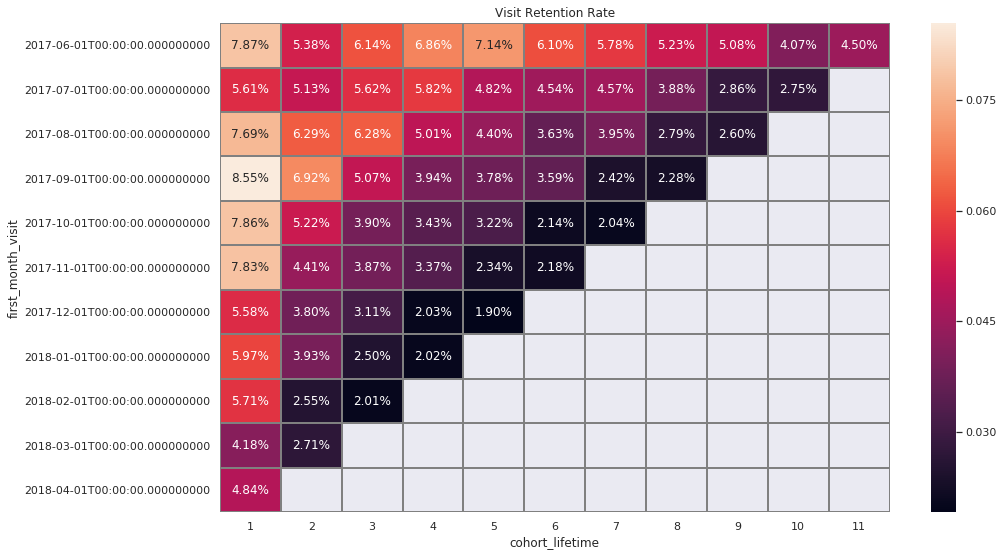

In [162]:
retention_pivot = (cohorts_one_source(visits)
                   .query('cohort_lifetime > 0')
                   .pivot_table(index='first_month_visit', columns='cohort_lifetime', values='retention')
                  )
plt.figure(figsize=(15, 9))
sb.heatmap(retention_pivot, annot=True, fmt='.2%', linewidths=1, linecolor='gray')
plt.title('Visit Retention Rate')
plt.show()

Показатели по удержанию клиентов очень низки. Интересно то, что уже через месяц лояльными остается не более 9% посетителей и далее этот процент падает еще сильнее до 2-5%.

In [100]:
buyers = orders.uid # список юзеров, которые что-то купили на сайте
sales = visits.query('uid in @buyers').merge(orders, how='left', on='uid')[['uid','buy_ts', 'revenue','start_ts','end_ts','session_month']]
# оставляем только те записи, когда время покупки между началом и концом сессии:
sales['bought_in_session'] = (sales['buy_ts'] < sales['end_ts']) & (sales['start_ts'] < sales['buy_ts'])
sales = sales.query('bought_in_session == True')

# время, через которое после начала сессии пользователь сделал покупку
sales['bought_within'] = ((sales['buy_ts'] - sales['start_ts']).dt.seconds) / 60 
sales

,uid,buy_ts,revenue,start_ts,end_ts,session_month,bought_in_session,bought_within
1,16174680259334210214,2018-03-09 20:25:00,2.33,2018-03-09 20:05:00,2018-03-09 20:33:00,3,True,20.0
12,16007536194108375387,2017-10-28 00:01:00,1.53,2017-10-27 23:56:00,2017-10-28 00:04:00,10,True,5.0
29,16007536194108375387,2017-09-04 12:46:00,2.44,2017-09-04 12:44:00,2017-09-04 12:51:00,9,True,2.0
797,8056418121947262981,2017-10-28 14:32:00,4.28,2017-10-28 14:29:00,2017-10-28 14:37:00,10,True,3.0
1602,8056418121947262981,2017-06-26 09:14:00,3.67,2017-06-26 08:13:00,2017-06-26 09:16:00,6,True,61.0
...,...,...,...,...,...,...,...,...
761795,6752020629696526518,2017-12-04 12:46:00,4.15,2017-12-04 12:42:00,2017-12-04 12:50:00,12,True,4.0
761796,11750532881998794555,2017-11-20 23:43:00,3.67,2017-11-20 23:33:00,2017-11-20 23:44:00,11,True,10.0
761797,11202626539189016002,2017-11-29 20:33:00,3.05,2017-11-29 20:27:00,2017-11-29 20:48:00,11,True,6.0
761798,12734910664455613822,2018-04-23 21:16:00,0.49,2018-04-23 21:11:00,2018-04-23 21:19:00,4,True,5.0


Заметим, что по каким-то причинам не все покупки попадают в границы сессий, должно быть, это ошибки в отправке аналитической телеметрии.

Посмотрим, сколько в среднем занимает времени сделать покупку, считая от начала сессии до момента совершения покупки:

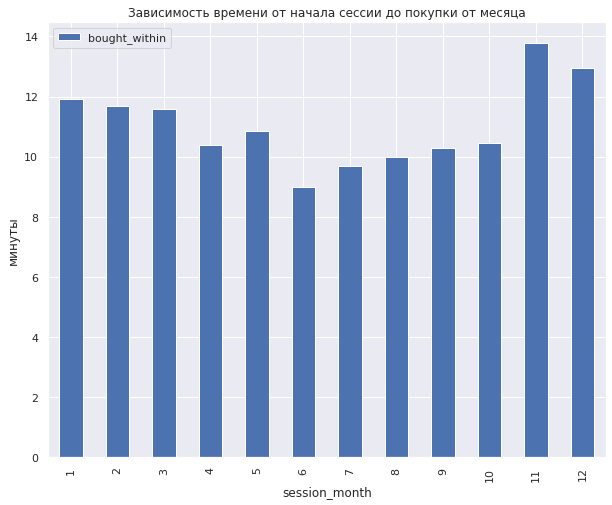

In [101]:
sales.groupby('session_month')['bought_within'].mean().reset_index().plot(kind='bar', x='session_month', y='bought_within',figsize=(10,8))
plt.ylabel('минуты')
plt.title('Зависимость времени от начала сессии до покупки от месяца')
plt.show()

В принципе нельзя сказать, что ситуация как-то зависит от месяца. Между заходом на сайт и покупкой проходит 10-12 минут. 

Определим число покупок в месяц:

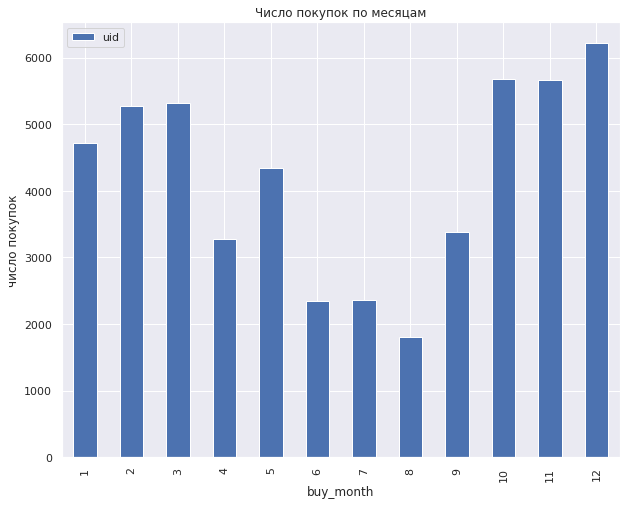

In [102]:
orders['buy_month'] = orders['buy_ts'].dt.month
orders.groupby('buy_month')['uid'].count().reset_index().plot(kind='bar', x='buy_month', y='uid',figsize=(10,8))
plt.title('Число покупок по месяцам')
plt.ylabel('число покупок')
plt.show()

В летние месяцы покупок в 2-3 раза меньше, чем в остальное время. Это можно объяснить тем, что в театрах сезон обычно начинается осенью, летом представлений, как правило, меньше. Но все равно в таком случае не мешает проверить, все ли было в порядке с сервисом в эти месяцы.

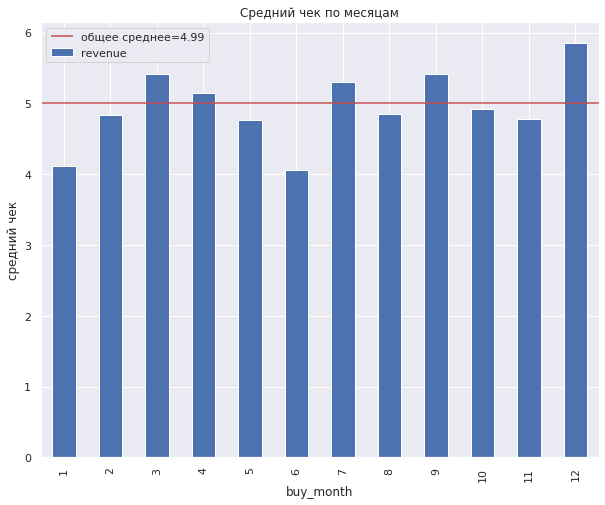

In [103]:
# средний чек по месяцам
ax=orders.groupby('buy_month')['revenue'].mean().reset_index().plot(kind='bar', x='buy_month', y='revenue', figsize=(10,8))
# красной горизонтальной линией обозначим годовой средний чек
ax.hlines(orders['revenue'].mean(), -1, 12, color='r', label='общее среднее=4.99')
plt.title('Средний чек по месяцам')
plt.ylabel('средний чек')
plt.legend()
plt.show()

Средний чек не сильно отличается от месяца к месяцу. Малое число покупок в летние месяцы, как видим, не сильно повлияло на средний чек.

Чтобы рассчитать затраты по привлечению клиентов в каждом источнике рекламы, нужно каждой покупке поставить в соответствие источник рекламы, из которого этот клиент пришел. Так как один и тот же клиент мог в разное время перейти из разных источников, мы будем считать, что покупка сделана благодаря источнику, соответствующему первому заходу на сайт.

In [127]:
# делаем таблицу для когортного анализа в общем и в отдельности по каждому каналу привлечения

# присоединяем к дате первого визита на сайт рекламный источник, из которого пришел клиент
first_visit_source = (visits.groupby(['uid'])
                      .agg({'start_ts':'min'})
                      .reset_index()
                      .merge(visits[['uid','start_ts','source_id']], on=['uid','start_ts'],how='left')
                     )
first_visit_source['start_ts'] = first_visit_source['start_ts'].dt.date
first_visit_source['start_ts'] = pd.to_datetime(first_visit_source['start_ts'])

# присоединяем данные о покупках: время, выручку
costs_orders_source = (first_visit_source
                       .merge(orders, how='right', on='uid')
                      )
costs_orders_source['buy_ts'] = costs_orders_source['buy_ts'].astype('datetime64[M]')
# добавляем месяц первой покупки
costs_orders_source = (costs_orders_source
                       .merge
                       (costs_orders_source
                              .groupby('uid')
                              .agg({'buy_ts':'min'})
                              .rename(columns={'buy_ts':'first_order_month'})
                              .reset_index(), on='uid',how='left')
                       
                      )
# возраст когорт
costs_orders_source['cohort_lifetime'] = (((costs_orders_source['buy_ts'] - costs_orders_source['first_order_month']) / np.timedelta64(1,'M'))
                                          .round()
                                          .astype('int')
                                         )
costs_orders_source = costs_orders_source.rename(columns={'buy_ts':'order_month'})
costs_orders_source

,uid,start_ts,source_id,order_month,revenue,buy_month,first_order_month,cohort_lifetime
0,313578113262317,2017-09-18,2,2018-01-01,0.55,1,2018-01-01,0
1,1575281904278712,2017-06-03,10,2017-06-01,1.22,6,2017-06-01,0
2,1575281904278712,2017-06-03,10,2017-06-01,1.83,6,2017-06-01,0
3,2429014661409475,2017-10-11,3,2017-10-01,73.33,10,2017-10-01,0
4,2464366381792757,2018-01-27,5,2018-01-01,2.44,1,2018-01-01,0
...,...,...,...,...,...,...,...,...
50409,18445407535914413204,2017-09-22,3,2017-09-01,0.24,9,2017-09-01,0
50410,18445407535914413204,2017-09-22,3,2017-09-01,0.12,9,2017-09-01,0
50411,18445601152732270159,2017-08-07,2,2018-03-01,4.22,3,2018-03-01,0
50412,18446156210226471712,2017-11-07,3,2018-02-01,9.78,2,2018-02-01,0


Полученная таблица *costs_orders_source* - очень важный результат. Теперь используя ее, можно расчитать LTV и ROI как для всей выборки, так и по каждому рекламному каналу в отдельности.

Для начала проведем расчеты без деления на источники привлечения, рассчитаем LTV:

In [105]:
# заготовок финальной таблицы, считаем суммарную выручку в каждом месяце по когортам
cohorts_orders = costs_orders_source.groupby(['first_order_month','cohort_lifetime']).agg({'revenue':'sum'}).reset_index()
# найдем число людей в когорте:
cohort_orders_sizes = costs_orders_source.groupby('first_order_month').agg({'uid':'nunique'}).reset_index()
cohort_orders_sizes.columns = ['first_order_month', 'cohort_size']
cohorts_orders_final = cohorts_orders.merge(cohort_orders_sizes, on='first_order_month')
# считаем LTV
cohorts_orders_final['ltv'] = cohorts_orders_final['revenue'] / cohorts_orders_final['cohort_size']
cohorts_orders_final

,first_order_month,cohort_lifetime,revenue,cohort_size,ltv
0,2017-06-01,0,9557.49,2023,4.724414
1,2017-06-01,1,981.82,2023,0.485329
2,2017-06-01,2,885.34,2023,0.437637
3,2017-06-01,3,1931.30,2023,0.954671
4,2017-06-01,4,2068.58,2023,1.022531
...,...,...,...,...,...
73,2018-03-01,1,1063.05,3533,0.300892
74,2018-03-01,2,1114.87,3533,0.315559
75,2018-04-01,0,10600.69,2276,4.657597
76,2018-04-01,1,1209.92,2276,0.531599


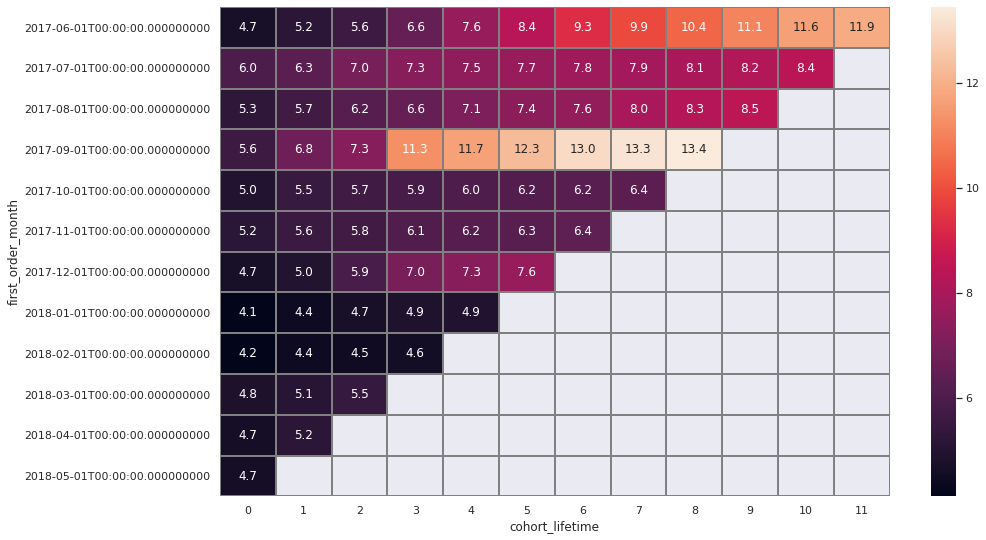

In [106]:
orders_pivot = cohorts_orders_final.pivot_table(index='first_order_month', columns='cohort_lifetime',values='ltv')
plt.figure(figsize=(15,9))
sb.heatmap(orders_pivot.cumsum(axis=1), annot=True, fmt='.1f', linewidths=1, linecolor='gray')
plt.show()

Через месяц выручка от каждой когорты падает почти в 10 раз. Очень маленький процент клиентов остается лояльным и продолжает покупать в следующие месяцы после момента первой покупки.

### Маркетинг

Посмотрим, насколько в целом окупился продукт. Для этого посчитаем ROI.

In [107]:
# выделим месяц покупки
costs['month'] = costs['dt'].astype('datetime64[M]')
# считаем суммарные траты за каждый месяц
costs_monthly = costs.groupby('month').agg({'costs':'sum'}).reset_index()
cohorts_orders_final = costs_monthly.merge(cohorts_orders_final, left_on='month', right_on='first_order_month')

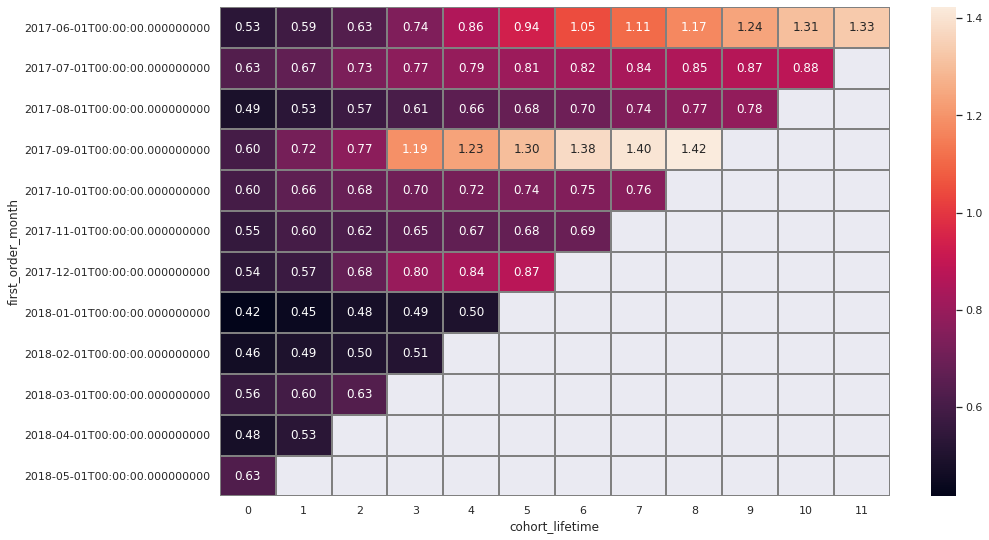

In [108]:
# считаем цену привлечения клиента в каждой когорте
cohorts_orders_final['cac'] = cohorts_orders_final['costs'] / cohorts_orders_final['cohort_size']
# считаем ROI
cohorts_orders_final['roi'] = cohorts_orders_final['ltv'] / cohorts_orders_final['cac']
report_roi = cohorts_orders_final.pivot_table(index='first_order_month', columns='cohort_lifetime', values='roi')
plt.figure(figsize=(15,9))
# выводим в таблице кумулятивный показатель
sb.heatmap(report_roi.cumsum(axis=1),annot=True, fmt='.2f', linewidths=1, linecolor='gray')
plt.show()

Окупилась только июньская и сентябрьская когорта на 6 и 3 месяц, соответственно. Остальные когорты далеки от окупаемости. Похоже, что их ROI в определенный момент вышел на уровень насыщения и стремительно расти дальше скорее всего не будет.

In [109]:
# средний ROI по когортам
report_roi.cumsum(axis=1).mean()

cohort_lifetime
0     0.540816
1     0.581985
2     0.631069
3     0.719740
4     0.782946
5     0.859876
6     0.896819
7     0.969951
8     1.053871
9     0.964488
10    1.094658
11    1.333982
dtype: float64

In [110]:
cohorts_orders_final

,month,costs,first_order_month,cohort_lifetime,revenue,cohort_size,ltv,cac,roi
0,2017-06-01,18015.00,2017-06-01,0,9557.49,2023,4.724414,8.905091,0.530530
1,2017-06-01,18015.00,2017-06-01,1,981.82,2023,0.485329,8.905091,0.054500
2,2017-06-01,18015.00,2017-06-01,2,885.34,2023,0.437637,8.905091,0.049145
3,2017-06-01,18015.00,2017-06-01,3,1931.30,2023,0.954671,8.905091,0.107205
4,2017-06-01,18015.00,2017-06-01,4,2068.58,2023,1.022531,8.905091,0.114825
...,...,...,...,...,...,...,...,...,...
73,2018-03-01,30415.27,2018-03-01,1,1063.05,3533,0.300892,8.608907,0.034951
74,2018-03-01,30415.27,2018-03-01,2,1114.87,3533,0.315559,8.608907,0.036655
75,2018-04-01,22289.38,2018-04-01,0,10600.69,2276,4.657597,9.793225,0.475594
76,2018-04-01,22289.38,2018-04-01,1,1209.92,2276,0.531599,9.793225,0.054282


Сколько всего потрачено средств на привлечение:

In [111]:
costs['costs'].sum()

329131.62

### LTV & ROI для каждого канала: определяем наиболее перспективные источники рекламы

Здесь мы не будем для каждого источника производить дополнительное деление по месяцу первой покупки каждого из клиентов. Когортой поэтому будем считать группу людей, сделавших покупку,прийдя из n-го источника, за всё время наблюдения независимо от даты первой покупки. Тогда размер когорты - это число клиентов, сделавших покупку, благодаря n-му источнику рекламы. Размерностью возраста когорты так же как и в общем случае будет один месяц. 

In [157]:
temp = (costs_orders_source
                     .groupby('source_id')
                     .agg({'uid':'nunique'})
                     .rename(columns={'uid':'cohort_size'})
                     .reset_index()
                    )
cohorts_by_source = costs_orders_source.merge(temp, how='left', on='source_id')
# удельный доход, то есть это доход одного заказа, деленный на размер когорты. Далее мы просуммируем по всем таким удельным доходам
# в пределах когорты и получим значение LTV для конкретного месяца. Далее суммируя кумулятивно, получим LTV
cohorts_by_source['revenue_per_one'] = cohorts_by_source['revenue'] / cohorts_by_source['cohort_size']
# считаем LTV
ltv_by_source = cohorts_by_source.pivot_table(index='source_id', columns='cohort_lifetime',values='revenue_per_one', aggfunc='sum').cumsum(axis=1)
# Сколько всего потрачено средств на привлечение для каждого источника
costs_by_source = costs.groupby('source_id')['costs'].sum().reset_index()
cohorts_by_source = cohorts_by_source.merge(costs_by_source, on='source_id', how='left')
cohorts_by_source['cac'] = cohorts_by_source['costs'] / cohorts_by_source['cohort_size']
# удельный ROI, то есть это доход одного заказа, деленный на размер когорты и деленный на САС
cohorts_by_source['roi_per_one'] = cohorts_by_source.revenue_per_one / cohorts_by_source.cac
# roi
roi_by_source = cohorts_by_source.pivot_table(index='source_id', columns='cohort_lifetime',values='roi_per_one', aggfunc='sum')
roi_by_source.cumsum(axis=1)

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
source_id,,,,,,,,,,,,
1,0.868964,0.997220,1.106797,1.208097,1.264397,1.299583,1.335420,1.386377,1.432026,1.459000,1.477115,1.492351
2,0.541456,0.657607,0.789183,0.921301,0.978708,1.022240,1.052232,1.068387,1.079204,1.084587,1.093813,1.096191
3,0.332639,0.352633,0.363392,0.370702,0.375968,0.379491,0.381493,0.383335,0.384718,0.385251,0.385579,0.385725
4,0.767890,0.799386,0.815510,0.837698,0.854664,0.873244,0.902292,0.909103,0.912314,0.918940,0.927706,0.928280
5,0.648265,0.682064,0.709620,0.910585,0.937135,0.969766,0.986648,0.998196,1.005004,1.014115,1.015884,1.016750
7,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.767568,0.823280,0.877961,0.921810,0.949997,0.975208,0.996618,1.012837,1.038751,1.042150,1.043844,NaN
10,0.722145,0.736996,0.743259,0.752084,0.756178,0.758461,0.760381,0.763180,0.763757,0.764335,NaN,NaN


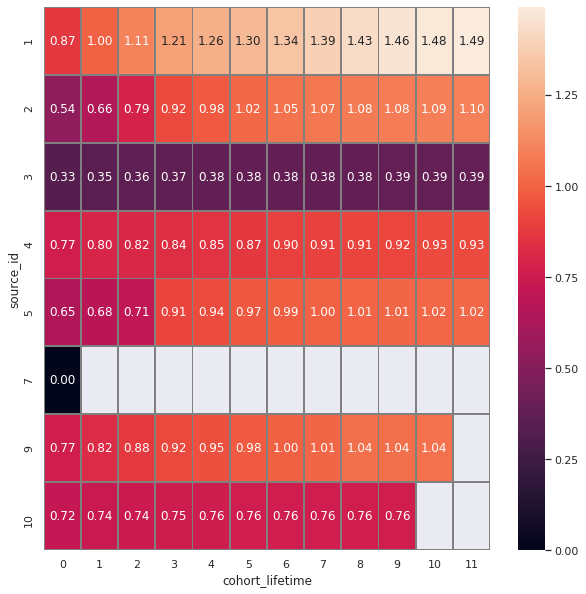

In [158]:
plt.figure(figsize=(10,10))
sb.heatmap(roi_by_source.cumsum(axis=1),annot=True, fmt='.2f', linewidths=1, linecolor='gray')
plt.show()

Источники номер 3 и 10 очень плохо окупаются. Самые успешные - это 1,2,5,9.

In [113]:
# смотрим распределение по каналам привлечения людей, пришедших на сайт И сделавших покупку
clients_by_source = (visits
                     .query('uid in @buyers')
                     .groupby('source_id')
                     .agg({'uid':'nunique'})
                     .reset_index()
                     .rename(columns={'uid':'clients'})
                    )
clients_by_source

,source_id,clients
0,1,7138
1,2,7304
2,3,13846
3,4,14252
4,5,10156
5,7,1
6,9,2793
7,10,1773


In [114]:
# таблица пригодится для расчета стоимости привлечения одного клиента в зависимости от источника
acquis_cost_source = costs_by_source.merge(clients_by_source, how='left', on='source_id')
acquis_cost_source

,source_id,costs,clients
0,1,20833.27,7138
1,2,42806.04,7304
2,3,141321.63,13846
3,4,61073.60,14252
4,5,51757.10,10156
5,9,5517.49,2793
6,10,5822.49,1773


In [115]:
acquis_cost_source['cac_by_source'] = acquis_cost_source['costs'] / acquis_cost_source['clients']
acquis_cost_source

,source_id,costs,clients,cac_by_source
0,1,20833.27,7138,2.918642
1,2,42806.04,7304,5.860630
2,3,141321.63,13846,10.206676
3,4,61073.60,14252,4.285265
4,5,51757.10,10156,5.096209
5,9,5517.49,2793,1.975471
6,10,5822.49,1773,3.283976


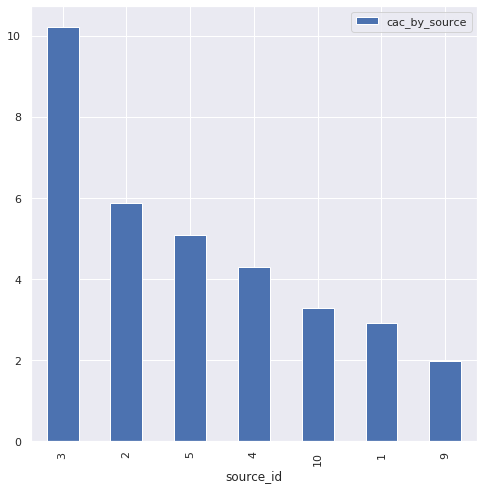

In [116]:
(acquis_cost_source
     .sort_values(by='cac_by_source', ascending=False)
     .plot(kind='bar', x='source_id',y='cac_by_source', figsize=(8,8))
)
plt.show()

У источника под номером "3" огромная цена привлечения клиента: денег инвестируем много, а приходит людей мало. Данный канал не эффективен, от него стоит отказаться и перенаправить ресурсы в другие более выгодные источники.

Посчитаем, сколько уходит ресурсов на привлечение через каждый из каналов по месяцам:

In [117]:
costs_month_source = costs.groupby(['month', 'source_id']).agg({'costs':'sum'}).reset_index()
costs_month_source

,month,source_id,costs
0,2017-06-01,1,1125.61
1,2017-06-01,2,2427.38
2,2017-06-01,3,7731.65
3,2017-06-01,4,3514.80
4,2017-06-01,5,2616.12
...,...,...,...
79,2018-05-01,3,9411.42
80,2018-05-01,4,4214.21
81,2018-05-01,5,3669.56
82,2018-05-01,9,362.17


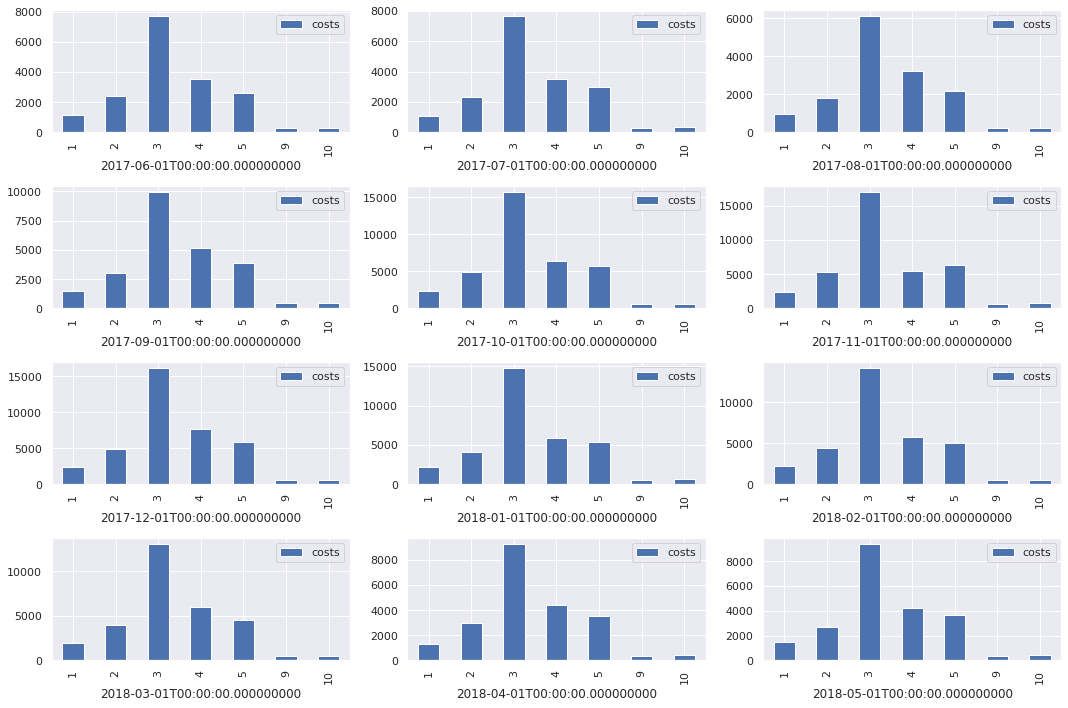

In [118]:
# построим графики суммарных затрат на привлечение клиентов в зависимости от источника для всех месяцев наблюдения
fig, ax = plt.subplots(4,3, figsize=(15,10))
months = costs_month_source['month'].unique()
k=0
for i in range(0,4):
    for j in range(0,3):
        costs_month_source.query('month == @months[@k]').plot(kind='bar', x='source_id',y='costs', ax=ax[i,j])
        ax[i,j].set_xlabel(months[k])
        k+=1
        
plt.tight_layout()

Видим, что распределение средств на маркетинг по разным каналам в каждый месяц качественно одинаково. На третий канал тратится больше всего, на 9 и 10-й меньше всего.

А теперь посчитаем затраты на маркетинг просто по месяцам:

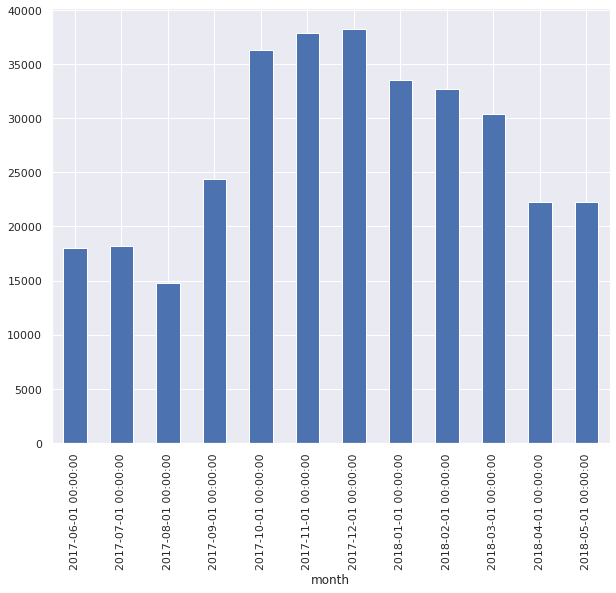

In [119]:
costs.groupby('month')['costs'].sum().plot(kind='bar', figsize=(10,8))
plt.show()

Летом 2017 года и в апреле-мае 2018 тратили на маркетинг меньше всего, возможно, поэтому число покупок в это время так же самое меньшее среди остальных месяцев.

In [121]:
orders

,buy_ts,revenue,uid,buy_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,6
1,2017-06-01 00:25:00,0.55,11627257723692907447,6
2,2017-06-01 00:27:00,0.37,17903680561304213844,6
3,2017-06-01 00:29:00,0.55,16109239769442553005,6
4,2017-06-01 07:58:00,0.37,14200605875248379450,6
...,...,...,...,...
50409,2018-05-31 23:43:00,3.67,1805512004303848280,5
50410,2018-05-31 23:50:00,4.64,12296626599487328624,5
50411,2018-05-31 23:50:00,5.80,11369640365507475976,5
50412,2018-05-31 23:54:00,0.30,1786462140797698849,5


In [122]:
orders.groupby('buy_month')['uid'].count()

buy_month
1     4721
2     5281
3     5326
4     3273
5     4346
6     2354
7     2363
8     1807
9     3387
10    5679
11    5659
12    6218
Name: uid, dtype: int64

## Общий вывод.

- стоит в 10 раз сократить затраты на привлечение клиентов через 3, 4 и 10 источники и перераспределить эти средства между 1,2,9 каналами. Возможно, от канала 3 стоит отказаться, он вносит большой вклад в убыточность;
- в летние месяцы покупок в 2-3 раза меньше, чем в остальное время. Это можно объяснить тем, что в театрах сезон обычно начинается осенью, летом представлений, как правило, меньше. Но все равно в таком случае не мешает проверить, все ли было в порядке с сервисом в эти месяцы;
- у сервиса крайне низкий retention: после первого визита на сайт в следующий месяц переходит лишь 8-9% аудитории. Среди каналов рекламы самыми успешными по показателю удержания являются 1,2 и 9;
- низкий retention и неэффективные траты на маркетинг в результате дают плохую окупаемость. Согласно среднему по всем когортам значению ROI, затраты окупаются только через 8 месяцев.